In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np
sys.path.append('../')
sys.path.append("../../../tejaas/")
from iotools.readRPKM import ReadRPKM
import pandas as pd
import numpy as np
import pandas as pd
import gzip
from utils import utils
# from gtex_normalization import normalize_expression

def centerscale_expr(Y):
    if isinstance(Y, pd.DataFrame):
        Y_cent = (Y.values - np.mean(Y.values, axis = 1).reshape(-1, 1)) / np.std(Y.values, axis = 1).reshape(-1, 1)
        Y_cent = pd.DataFrame(Y_cent, index=Y.index, columns=Y.columns)
        Y_cent.index.name = Y.index.name
    else:
        Y_cent = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return Y_cent

In [31]:
def get_donors(path):
    donor_ids = list()
    with open(path, 'r') as instream:
        # skip first two lines
        next(instream)
        next(instream)
        for line in instream:
            donor_ids.append(line.strip().split()[0])
    return donor_ids

def read_gct(gct_file, donor_ids):
    """
    Load GCT as DataFrame
    """    
    df = pd.read_csv(gct_file, sep='\t', skiprows=2, index_col=0)
    df.drop('Description', axis=1, inplace=True)
    df.index.name = 'gene_id'
    df = df[[i for i in df.columns if '-'.join(i.split('-')[:2]) in donor_ids]]
    return df

import scipy.stats as stats

def normalize_quantiles(df):
    """
    Note: replicates behavior of R function normalize.quantiles from library("preprocessCore")  

    Reference:
     [1] Bolstad et al., Bioinformatics 19(2), pp. 185-193, 2003
    
    Adapted from https://github.com/andrewdyates/quantile_normalize
    """
    
    M = df.values.copy()
    
    Q = M.argsort(axis=0)
    m,n = M.shape

    # compute quantile vector
    quantiles = np.zeros(m)
    for i in range(n):
        quantiles += M[Q[:,i],i]
    quantiles = quantiles / n
    
    for i in range(n):
        # Get equivalence classes; unique values == 0
        dupes = np.zeros(m, dtype=np.int)
        for j in range(m-1):
            if M[Q[j,i],i]==M[Q[j+1,i],i]:
                dupes[j+1] = dupes[j]+1
                
        # Replace column with quantile ranks
        M[Q[:,i],i] = quantiles

        # Average together equivalence classes
        j = m-1
        while j >= 0:
            if dupes[j] == 0:
                j -= 1
            else:
                idxs = Q[j-dupes[j]:j+1,i]
                M[idxs,i] = np.median(M[idxs,i])
                j -= 1 + dupes[j]
        assert j == -1
    
    return pd.DataFrame(M, index=df.index, columns=df.columns)
      
def inverse_normal_transform(M):
    """
    Transform rows to a standard normal distribution
    """
    R = stats.mstats.rankdata(M, axis=1)  # ties are averaged
    if isinstance(M, pd.DataFrame):
        Q = pd.DataFrame(stats.norm.ppf(R/(M.shape[1]+1)), index=M.index, columns=M.columns)
    else:
        Q = stats.norm.ppf(R/(M.shape[1]+1))
    return Q

def tmm_normalize(qc_counts):
    # TMM transformation
    tmm_counts_df = edgeR_cpm(qc_counts, normalized_lib_sizes=True)
    norm_df = inverse_normal_transform(tmm_counts_df)
    return centerscale_expr(norm_df)

def qn_normalize(qc_expr):
    # QN transformation
    qn_df = normalize_quantiles(qc_expr)
    norm_df_qn = inverse_normal_transform(qn_df)
    return centerscale_expr(norm_df_qn)


### Apply LM correction (python)
from sklearn import linear_model

def lmcorrect(expression_df, cov_df):   
    donor_ids = expression_df.columns

    #sort donors
    cov_df = cov_df[expression_df.columns]

    reg = linear_model.LinearRegression()
    reg.fit(cov_df.T, expression_df.T)

    # reg.score(df_cov.T, crop_expression_df.T)
    # print(reg.coef_)
    residuals = expression_df - reg.predict(cov_df.T).T
    return residuals, reg.coef_

def correct_lasso(expression_df, cov_df, alpha=0.05):   
    donor_ids = expression_df.columns

    #sort donors
    cov_df = cov_df[expression_df.columns]

    reg = linear_model.Lasso(alpha=alpha)
    reg.fit(cov_df.T, expression_df.T)

    residuals = expression_df - reg.predict(cov_df.T).T
    return residuals, reg.coef_

def correct_ridge(expression_df, cov_df, alpha=0.05):   
    donor_ids = expression_df.columns

    #sort donors
    cov_df = cov_df[expression_df.columns]

    reg = linear_model.Ridge(alpha=alpha)
    reg.fit(cov_df.T, expression_df.T)

    residuals = expression_df - reg.predict(cov_df.T).T
    return residuals, reg.coef_

def correct_lasso_iterative(expression_df, df_cov, alpha=0.05):   
    #sort donors
    if not isinstance(expression_df, pd.DataFrame):
        print("Expression matrix must be a DataFrame")
        raise
    sort_df_cov = df_cov[expression_df.columns]
    
    residuals = np.zeros(expression_df.shape)
    coefs = np.zeros((expression_df.shape[0], sort_df_cov.shape[0]))
    for i in range(expression_df.shape[0]):
        reg = linear_model.Lasso(alpha = alpha)
        reg.fit(sort_df_cov.T, expression_df.iloc[i])

        # print(i, reg.score(sort_df_cov.T, expression_df.iloc[i].T), reg.coef_)
        residuals[i] = expression_df.iloc[i] - reg.predict(sort_df_cov.T).T
        coefs[i,:] = reg.coef_
    df_residuals = pd.DataFrame(residuals, columns=expression_df.columns, index=expression_df.index)
    df_residuals.index.name = expression_df.index.name
    return df_residuals, coefs

def correct_ridge_iterative(expression_df, df_cov, alpha=0.05):   
    #sort donors
    if not isinstance(expression_df, pd.DataFrame):
        print("Expression matrix must be a DataFrame")
        raise
    sort_df_cov = df_cov[expression_df.columns]
    
    residuals = np.zeros(expression_df.shape)
    coefs = np.zeros((expression_df.shape[0], sort_df_cov.shape[0]))
    for i in range(expression_df.shape[0]):
        reg = linear_model.Ridge(alpha = alpha)
        reg.fit(sort_df_cov.T, expression_df.iloc[i])

        # print(i, reg.score(sort_df_cov.T, expression_df.iloc[i].T), reg.coef_)
        residuals[i] = expression_df.iloc[i] - reg.predict(sort_df_cov.T).T
        coefs[i,:] = reg.coef_
    df_residuals = pd.DataFrame(residuals, columns=expression_df.columns, index=expression_df.index)
    df_residuals.index.name = expression_df.index.name
    return df_residuals, coefs

In [3]:
import warnings

def QC_expression(counts_df, expr_df, expr_threshold=0.1, sample_frac_threshold=0.2, count_threshold=6):
    ns = expr_df.shape[1]

    mask = (
        (np.sum(expr_df>=expr_threshold,axis=1)>=sample_frac_threshold*ns) &
        (np.sum(counts_df>=count_threshold,axis=1)>=sample_frac_threshold*ns)
    ).values
    
    return centerscale_expr(expr_df.loc[mask]), counts_df.loc[mask] 

def edgeR_calcNormFactors(counts_df, ref=None, logratio_trim=0.3, sum_trim=0.05, acutoff=-1e10, verbose=False):
    """
    Calculate TMM (Trimmed Mean of M values) normalization.
    Reproduces edgeR::calcNormFactors.default
    Scaling factors for the library sizes that minimize the log-fold changes between the samples for most genes.
    Effective library size: TMM scaling factor * library size
    References:
     [1] Robinson & Oshlack, 2010
     [2] R functions:
          edgeR::calcNormFactors.default
          edgeR:::.calcFactorWeighted
          edgeR:::.calcFactorQuantile
    """

    # discard genes with all-zero counts
    Y = counts_df.values.copy()
    allzero = np.sum(Y>0,axis=1)==0
    if np.any(allzero):
        Y = Y[~allzero,:]

    # select reference sample
    if ref is None:  # reference sample index
        f75 = np.percentile(Y/np.sum(Y,axis=0), 75, axis=0)
        ref = np.argmin(np.abs(f75-np.mean(f75)))
        if verbose:
            print('Reference sample index: '+str(ref))

    N = np.sum(Y, axis=0)  # total reads in each library

    # with np.errstate(divide='ignore'):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        logR = np.log2((Y/N).T / (Y[:,ref]/N[ref])).T  # log fold change; Mg in [1]
        absE = 0.5*(np.log2(Y/N).T + np.log2(Y[:,ref]/N[ref])).T  # average log relative expression; Ag in [1]
        v = (N-Y)/N/Y
        v = (v.T + v[:,ref]).T  # w in [1]

    ns = Y.shape[1]
    tmm = np.zeros(ns)
    for i in range(ns):
        fin = np.isfinite(logR[:,i]) & np.isfinite(absE[:,i]) & (absE[:,i] > acutoff)
        n = np.sum(fin)

        loL = np.floor(n*logratio_trim)+1
        hiL = n + 1 - loL
        loS = np.floor(n*sum_trim)+1
        hiS = n + 1 - loS
        rankR = stats.rankdata(logR[fin,i])
        rankE = stats.rankdata(absE[fin,i])
        keep = (rankR >= loL) & (rankR <= hiL) & (rankE >= loS) & (rankE <= hiS)
        # in [1], w erroneously defined as 1/v ?
        tmm[i] = 2**(np.nansum(logR[fin,i][keep]/v[fin,i][keep]) / np.nansum(1/v[fin,i][keep]))

    tmm = tmm / np.exp(np.mean(np.log(tmm)))
    return tmm


def edgeR_cpm(counts_df, tmm=None, normalized_lib_sizes=True):
    """
    Return edgeR normalized/rescaled CPM (counts per million)
    Reproduces edgeR::cpm.DGEList
    """
    lib_size = counts_df.sum(axis=0)
    if normalized_lib_sizes:
        if tmm is None:
            tmm = edgeR_calcNormFactors(counts_df)
        lib_size = lib_size * tmm
    return counts_df / lib_size * 1e6

In [26]:
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/main/tissues.txt"
tissuenames, descriptions = utils.read_tissues(tissue_file)
tissuenames = ["ms"]
# tissues = ["gtex-"+t for t in tissuenames]

processpath="/cbscratch/franco/trans-eqtl/new_preprocess_dec2019_nopc/gtex_v8/expression/"

# tissue="ms"
for tissue in tissuenames:
    print(tissue)
    rpkmpath=processpath+"tpms/{:s}_tpm.gct".format(tissue)
    countspath=processpath+"tpms/{:s}_counts.gct".format(tissue)
    donorspath ="/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8.sample"

    # expression_threshold=0.1    # 'Selects genes with > expression_threshold expression in at least min_samples')
    # count_threshold=5,          # 'Selects genes with > count_threshold reads in at least min_samples')
    min_samples=10              # 'Minimum number of samples that must satisfy thresholds')

    donor_ids = get_donors(donorspath)
    expression_df = read_gct(rpkmpath, donor_ids)
    counts_df = read_gct(countspath, donor_ids)

    if expression_df.shape[1] < min_samples:
        raise ValueError("tissue has less samples than threshold")

    expr_ids = list(expression_df.columns)
    tissue_counts_df = counts_df.loc[:,expr_ids]

    # match sample ids
    newcolumns = ["-".join(i.split("-")[:2]) for i in expr_ids]
    expression_df.columns = newcolumns
    tissue_counts_df.columns = newcolumns   
    
    # QC filtering
    # TPM filtering
    print('  * QC filtering')
    qc_tpm_expr, qc_counts = QC_expression(tissue_counts_df, expression_df)
    if not os.path.exists(os.path.join(processpath,"tpms")):
        os.makedirs(os.path.join(processpath,"tpms"))
    qc_tpm_expr.to_csv(os.path.join(processpath,"tpms","{:s}_tpms_qcfilter.txt".format(tissue)), sep="\t")
    qc_counts.to_csv(os.path.join(processpath,"tpms","{:s}_counts_qcfilter.txt".format(tissue)), sep="\t")

    # Apply TMM or QN normalization
    print('  * Applying QN')
    qn_expr  = centerscale_expr(qn_normalize(qc_tpm_expr))

    print('  * Applying TMM')
    tmm_expr = centerscale_expr(tmm_normalize(qc_counts))

    if not os.path.exists(os.path.join(processpath,"qn")):
        os.makedirs(os.path.join(processpath,"qn"))
    if not os.path.exists(os.path.join(processpath,"tmm")):
        os.makedirs(os.path.join(processpath,"tmm"))
    qn_expr.to_csv(os.path.join(processpath,"qn","{:s}_qn.txt".format(tissue)), sep="\t")
    tmm_expr.to_csv(os.path.join(processpath,"tmm","{:s}_tmm.txt".format(tissue)), sep="\t")


ms
  * Converting to TPM
Applying TMM transformation
Applying QN transformation


In [40]:
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/main/tissues.txt"
tissuenames, descriptions = utils.read_tissues(tissue_file)
tissuenames = ["ms"]
# tissues = ["gtex-"+t for t in tissuenames]

processpath="/cbscratch/franco/trans-eqtl/new_preprocess_dec2019_nopc/gtex_v8/expression/"

# tissue="ms"
for tissue in tissuenames:
    print(tissue)
    donorspath ="/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8.sample"
    qn_file = os.path.join(processpath,"qn","{:s}_qn.txt".format(tissue))
    tmm_file = os.path.join(processpath,"tmm","{:s}_tmm.txt".format(tissue))
    raw_file = os.path.join(processpath,"tpms","{:s}_tpms_qcfilter.txt".format(tissue))

    qn_df = pd.read_csv(qn_file, sep="\t", header=0, index_col=0)
    tmm_df = pd.read_csv(tmm_file, sep="\t", header=0, index_col=0)
    raw_df = centerscale_expr(pd.read_csv(raw_file, sep="\t", header=0, index_col=0))

    # load covariates
    covfile = processpath+"covariates/{:s}_nopeer_covariates_w_age.txt".format(tissue)
    df_cov = pd.read_table(covfile, header=0, index_col=0)

    # scale covariates
    means = np.mean(df_cov.T)
    stds = np.std(df_cov.T)
    diff = (df_cov.T - means) / stds
    scaled_df_cov = diff.T
    
#     qn_lasso, qn_lasso_coefs = correct_lasso_iterative(qn_df, scaled_df_cov)
#     tmm_lasso, tmm_lasso_coefs = correct_lasso_iterative(tmm_df, scaled_df_cov)
    raw_lasso_it, raw_lasso_coefs_it = correct_lasso_iterative(raw_df, scaled_df_cov, alpha=30)
    
#     raw_ridge_it, raw_ridge_coefs_it = correct_ridge_iterative(raw_df, scaled_df_cov, alpha=100)
    
    raw_lasso, raw_lasso_coefs = correct_lasso(raw_df, scaled_df_cov, alpha=30)
    
#     raw_ridge, raw_ridge_coefs = correct_ridge(raw_df, scaled_df_cov, alpha=100)


#     qn_cclm, qn_coefs = lmcorrect(qn_df, scaled_df_cov)
#     tmm_cclm, tmm_coefs = lmcorrect(tmm_df, scaled_df_cov)
    raw_cclm, raw_coefs = lmcorrect(raw_df, scaled_df_cov)

ms


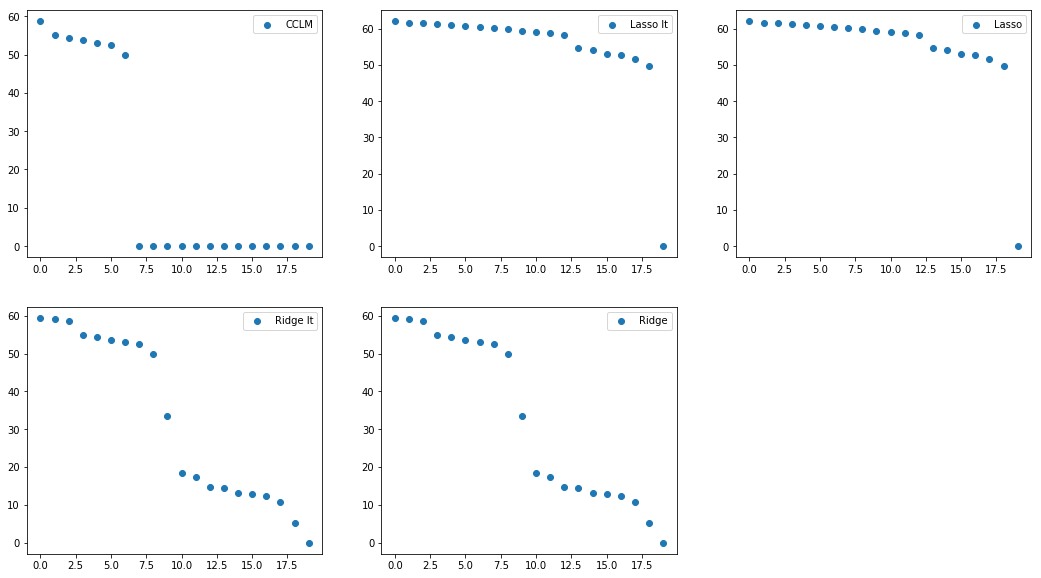

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18,10))

ax1  = fig.add_subplot(231)
GX = raw_cclm.values
Yt = GX.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
S2 = np.square(S)
ax1.scatter(np.arange(len(S[-20:])), S[-20:], label="CCLM")

ax2  = fig.add_subplot(232)
GX = raw_lasso_it.values
Yt = GX.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
S2 = np.square(S)
ax2.scatter(np.arange(len(S[-20:])), S[-20:], label="Lasso It")

ax3  = fig.add_subplot(233)
GX = raw_lasso.values
Yt = GX.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
S2 = np.square(S)
ax3.scatter(np.arange(len(S[-20:])), S[-20:], label="Lasso")

ax4  = fig.add_subplot(234)
GX = raw_ridge_it.values
Yt = GX.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
S2 = np.square(S)
ax4.scatter(np.arange(len(S[-20:])), S[-20:], label="Ridge It")

ax5  = fig.add_subplot(235)
GX = raw_ridge.values
Yt = GX.T
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
S2 = np.square(S)
ax5.scatter(np.arange(len(S[-20:])), S[-20:], label="Ridge")



ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
plt.show()